### Building Models for the IMDB Reviews Dataset

In [1]:
#importing libraries

import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#downloading and preparing dataset

imdb = tfds.load("imdb_reviews", as_supervised=True)

In [3]:
#train and test data

train_data, test_data = imdb['train'], imdb['test']

In [5]:
#train and test reviews and labels
train_reviews = train_data.map(lambda review, label: review)
train_labels = train_data.map(lambda review, label: label)

test_reviews = test_data.map(lambda review, label: review)
test_labels = test_data.map(lambda review, label: label)



In [6]:
#defining vectorize layer
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=10000)

#generating vocabulary on train_reviews
vectorize_layer.adapt(train_reviews)

In [16]:
#defining preprocessing function

def preprocessing_func(dataset):

    #apply vectorization layer to the string features
    dataset_sequences = dataset.map(lambda review, label: (vectorize_layer(review), label))

    #putting all elements in a single ragged batch
    dataset_sequences = dataset_sequences.ragged_batch(batch_size=dataset_sequences.cardinality())

    #output a tensor from the single batch
    sequences, labels = dataset_sequences.get_single_element()

    padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(),
                        padding="pre",
                        truncating="post",
                        maxlen=120)

    padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)
    labels = tf.data.Dataset.from_tensor_slices(labels)

    dataset_vectorized = tf.data.Dataset.zip(padded_sequences, labels)

    return dataset_vectorized


In [17]:
#preprocessing train and test data

train_dataset = train_data.apply(preprocessing_func)
test_dataset = test_data.apply(preprocessing_func)

In [18]:
#optmizing dataset for training

train_dataset_final = (train_dataset
                        .cache()
                        .shuffle(1000)
                        .batch(32)
                        .prefetch(tf.data.AUTOTUNE))

test_dataset_final = (test_dataset
                        .cache()
                        .batch(32)
                        .prefetch(tf.data.AUTOTUNE))                        


##### Trying on different models

* ##### Model-1: Flatten

In [27]:
#defining model

model_flatten = tf.keras.models.Sequential([
  tf.keras.Input(shape=(120,)),
  tf.keras.layers.Embedding(10000, 16),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(6, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")  
])

model_flatten.compile(loss="binary_crossentropy",
optimizer="adam",
metrics=['accuracy']
)

model_flatten.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 120, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │        11,526 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,533 (670.05 KB)

 Trainable params: 171,533 (670.05 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
#model training

history_flatten=model_flatten.fit(train_dataset_final,
epochs=10,
validation_data= test_dataset_final)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7358 - loss: 0.5045 - val_accuracy: 0.8245 - val_loss: 0.3890
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9012 - loss: 0.2502 - val_accuracy: 0.8198 - val_loss: 0.4195
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9695 - loss: 0.1067 - val_accuracy: 0.8029 - val_loss: 0.5250
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9937 - loss: 0.0333 - val_accuracy: 0.8092 - val_loss: 0.5954
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9979 - loss: 0.0142 - val_accuracy: 0.8058 - val_loss: 0.6594
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9991 - loss: 0.0062 - val_accuracy: 0.8020 - val_loss: 0.7356
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9996 - loss: 0.0026 - val_accuracy: 0.8015 - val_loss: 0.8083
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 6.1329e-04 - val_accuracy

* ##### Model-2: LSTM

In [29]:
#defining model with LSTM

model_lstm = tf.keras.models.Sequential([
    tf.keras.Input(shape=(120,)),
    tf.keras.layers.Embedding(10000, 16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_lstm.compile(loss="binary_crossentropy",
metrics=['accuracy'],
optimizer="adam")

model_lstm.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 120, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 172,941 (675.55 KB)

 Trainable params: 172,941 (675.55 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
history_lstm = model_lstm.fit(train_dataset_final, epochs=10, validation_data=test_dataset_final)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.4913 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.5516 - loss: 0.6805 - val_accuracy: 0.6216 - val_loss: 0.6602
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.7623 - loss: 0.4820 - val_accuracy: 0.8032 - val_loss: 0.4402
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.8688 - loss: 0.3172 - val_accuracy: 0.8209 - val_loss: 0.4148
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.8994 - loss: 0.2532 - val_accuracy: 0.8209 - val_loss: 0.4393
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.9263 - loss: 0.2018 - val_accuracy: 0.8092 - val_loss: 0.5325
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.9448 - loss: 0.1611 - val_accuracy: 0.8017 - val_loss: 0.5371
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.9596 - loss: 0.1252 - 

* ##### Model-3: GRU

In [ ]:
model_gru = tf.keras.models.Sequential([
    tf.keras.Input(shape=(120,)),
    tf.keras.layers.Embedding(10000, 16),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_gru.compile(loss="binary_crossentropy",
metrics=['accuracy'],
optimizer="adam")

model_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 120, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │         9,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169,997 (664.05 KB)

 Trainable params: 169,997 (664.05 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
history_gru=model_gru.fit(train_dataset_final, epochs=10, validation_data=test_dataset_final)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.9922 - loss: 0.0239 - val_accuracy: 0.7956 - val_loss: 1.0861
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.9944 - loss: 0.0171 - val_accuracy: 0.7945 - val_loss: 1.1998
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.9941 - loss: 0.0163 - val_accuracy: 0.8009 - val_loss: 1.1707
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9961 - loss: 0.0120 - val_accuracy: 0.7924 - val_loss: 1.2434
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9975 - loss: 0.0075 - val_accuracy: 0.7902 - val_loss: 1.3658
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9976 - loss: 0.0088 - val_accuracy: 0.7962 - val_loss: 1.3979
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9949 - loss: 0.0155 - val_accuracy: 0.7938 - val_loss: 1.3012
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9968 - loss: 0.0099 - 

* ##### Model-4: Convolution

In [31]:
model_conv = tf.keras.models.Sequential([
    tf.keras.Input(shape=(120,)),
    tf.keras.layers.Embedding(10000, 16),
    tf.keras.layers.Conv1D(128, 5, activation="relu"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_conv.compile(loss="binary_crossentropy",
metrics=['accuracy'],
optimizer="adam")

model_conv.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 120, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 116, 128)       │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 6)              │           774 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,149 (668.55 KB)

 Trainable params: 171,149 (668.55 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history_conv=model_conv.fit(train_dataset_final, epochs=10, validation_data=test_dataset_final)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9881 - loss: 0.0445 - val_accuracy: 0.7908 - val_loss: 1.2324
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9902 - loss: 0.0383 - val_accuracy: 0.7862 - val_loss: 1.2124
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9891 - loss: 0.0388 - val_accuracy: 0.7892 - val_loss: 1.3750
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9920 - loss: 0.0293 - val_accuracy: 0.7874 - val_loss: 1.5750
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9934 - loss: 0.0261 - val_accuracy: 0.7895 - val_loss: 1.5054
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9950 - loss: 0.0205 - val_accuracy: 0.7862 - val_loss: 1.6584
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9943 - loss: 0.0208 - val_accuracy: 0.7827 - val_loss: 1.5906
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9940 - loss: 0.0207 - val_accuracy: 0.

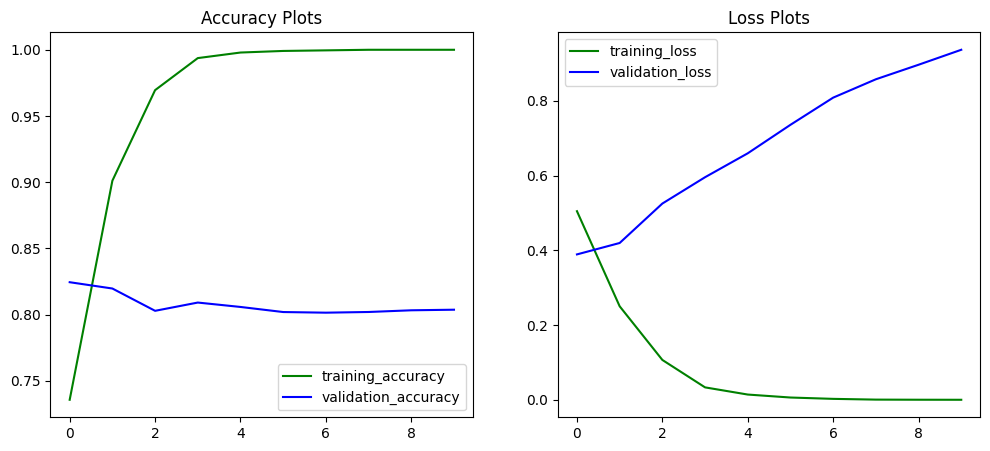

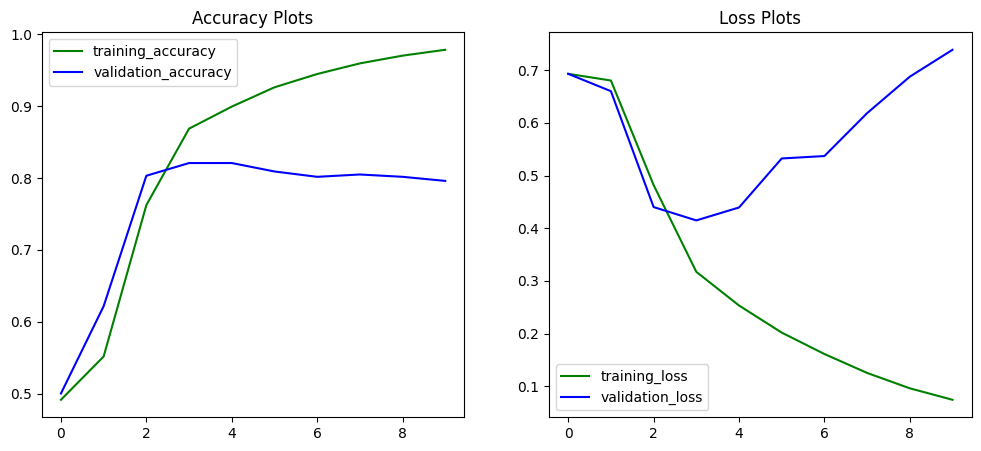

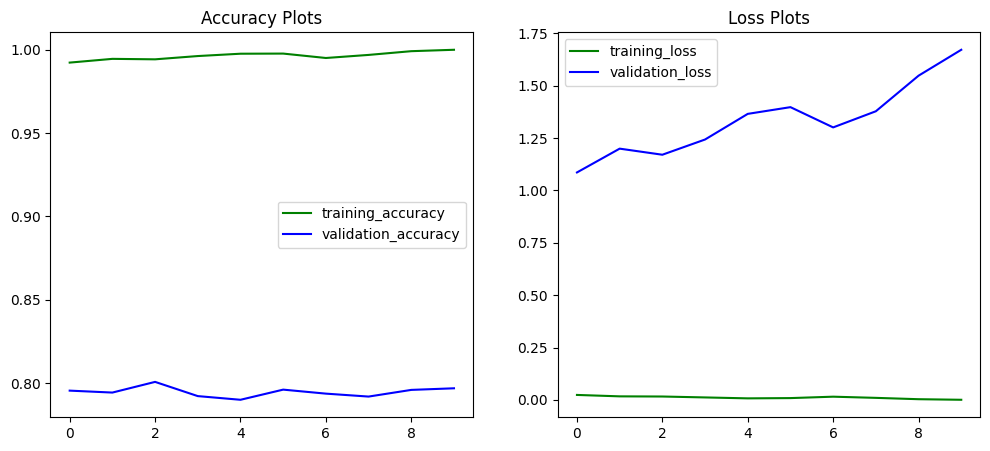

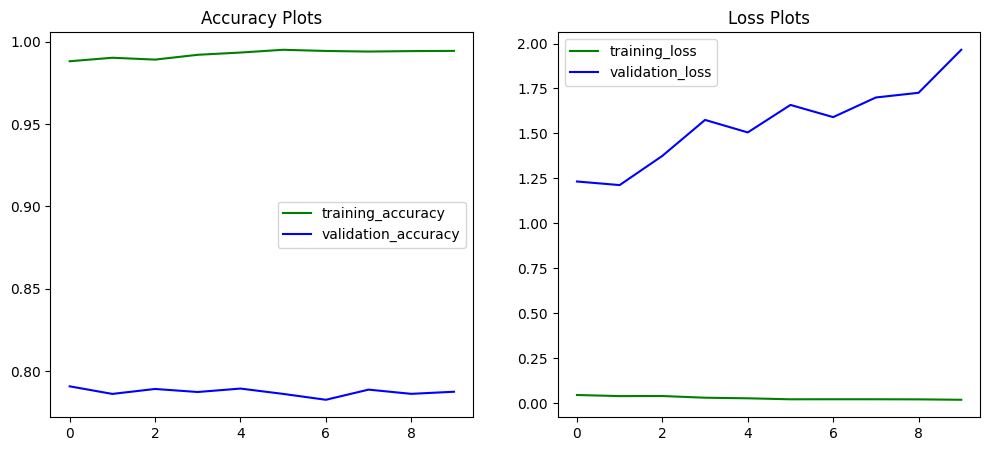

In [36]:
#Visualization

def visualize(history):

    plt.subplots(1,2,figsize=(12,5))
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))

    plt.subplot(1,2,1)
    plt.plot(epochs, accuracy, "g", label="training_accuracy")
    plt.plot(epochs, val_accuracy, 'b', label="validation_accuracy")
    plt.title("Accuracy Plots")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, "g", label="training_loss")
    plt.plot(epochs, val_loss, 'b', label="validation_loss")
    plt.title("Loss Plots")
    plt.legend()


visualize(history_flatten)
visualize(history_lstm)
visualize(history_gru)
visualize(history_conv)

